### Localization
This notebook can be used for the character and time localization, it is organized in the following steps:
1. Book/Chapter/Paragraph Splitting
2. File reading
3. Selecting the right NERs
4. Localization methods
5. Evaluation methods

#### Imports

In [1060]:
import pandas as pd
import re
from collections import Counter
import numpy as np
import math

### Book/Chapter/Paragraph splitting

In [1003]:
def read_book(booknum):
    bookstarts = [50, 17287, 37378, 61857, 89432, 119494, 152540, 177800, 202059]
    f = open("data.txt", "r", encoding="utf8")
    book = ''
    i = 0
    for line in f:
        if i < bookstarts[booknum] and i > bookstarts[booknum-1]:
            book = book + line
        i = i + 1
    return book

# book 1 has 41, 49, 63, 71, 111, 124, 103, 145
# found is 41, 49, 63, 71, 111, 124, 0, 0 
def split_into_chapters(booknum, book):
    if booknum <7:
        return re.split(r'\n[0-9]+\n\n', book)
    else:
        # needs refinement
        return re.split(r'[A-Z ]+\n\n', book)
    
def split_into_paragraphs(text):
    splitted = text.split('\n')
    return [x for x in splitted if x != '']

def get_number_paragraphs_per_chapter():
    totalpars = []
    totalchar = []
    for booknum in range(1,9):
        book = read_book(booknum)
        chapters =  split_into_chapters(booknum, book)
        paragraphamount = [] 
        characteramount = []
        totalcharamount = 0
        for chapter in chapters:
            paragraphnum = len(split_into_paragraphs(chapter))
            paragraphamount.append(paragraphnum)
            totalcharamount = totalcharamount + len(chapter)
            characteramount.append(totalcharamount)
        totalpars.append(paragraphamount)
        totalchar.append(characteramount)
    return totalpars, totalchar

### Read Files

In [1004]:
# Reads the NER gotten from BERT
def read_fromBERT():
    nerbert = []
    for i in range(1,9):
        path = "BERT/NER_BERT_Book" + str(i) + ".csv"
        f = open(path, encoding='utf-8', errors='ignore')
        lines = f.read()
        split = lines.split("\n")
        nerlist = []
        lastindex = 0
        chapterlist = []
        for item in split:
            line = item.split(',')
            if len(line)>2:
                if int(line[-1]) < lastindex:
                    nerlist.append(chapterlist)
                    chapterlist = [[''.join(line[:len(line)-2]), line[-2], line[-1]]]
                    lastindex = 0
                else:
                    chapterlist.append([''.join(line[:len(line)-2]), line[-2], line[-1]])
                    lastindex = int(line[-1])
        nerbert.append(nerlist)
    return nerbert

# Reads the NER gotten from FLAIR
def read_fromFLAIR(totalchar):
    nerflair = []
    for i in range(1, 9): 
        path = "NER_FLAIR/ner" + str(i) + '.txt'
        f = open(path, encoding='utf-8')
        lines = f.readlines()
        nerlist = []
        chapterlist = []
        curchap = 0
        on = False
        for line in lines:
            split = line.split(" ")
            intindex = re.search(r'\d+', split[-1][:-1])
            if intindex != None:
                if curchap < len(totalchar[i-1]):
                    if int(intindex.group()) > totalchar[i-1][curchap]:
                        curchap = curchap + 1
                        nerlist.append(chapterlist)
                        chapterlist = []   
            chapterlist.append([' '.join(split[:len(split)-2]), split[-2], split[-1][:-1]])
                                                                                     
        nerlist.append(chapterlist)
        nerflair.append(nerlist)
    return nerflair

# reads the location information with longitude and latitides from csv
def read_locs():
    return pd.read_csv('locs_lonlat.csv')

### Select only people and locations from ner lists

In [1006]:
# selects only the people and the locations from the input NERS
def select_people_and_locs_only(nerfrombert):
    peopleandlocs = []
    for book in nerfrombert:
        for ner in book:
            if ner[1] == 'B-PER' or ner[1] == 'PERSON':
                peopleandlocs.append(ner)
            elif ner[1] == 'B-LOC' or ner[1] == 'GPE' or ner[1] == 'LOC':
                peopleandlocs.append(ner)
    return peopleandlocs

def select_people_and_locs_only_chapters(nerfrombert):
    peopleandlocs = []
    for book in nerfrombert:
        perbook = []
        for chapter in book:
            chapters = []
            for ner in chapter:
                if ner[1] == 'B-PER' or ner[1] == 'PERSON':
                    chapters.append(ner)
                elif ner[1] == 'B-LOC' or ner[1] == 'GPE' or ner[1] == 'LOC':
                    chapters.append(ner)
            perbook.append(chapters)
        peopleandlocs.append(perbook)
    return peopleandlocs

def select_people_and_times_only(nerlist, onlylocs=False):
    total = []
    for book in nerlist:
        perbook = []
        for chapter in book:
            chapters = []
            for ner in chapter:
                if onlylocs:
                    if ner[1] == 'DATE':
                        chapters.append(ner)
                else:
                    if ner[1] == 'DATE' or ner[1] == 'B-PER' or ner[1] == 'PERSON':
                        chapters.append(ner)
            perbook.append(chapters)
        total.append(perbook)
    return total           

### Localization Methods

#### Helper methods

In [1051]:
def get_coordinates(locations):
    totallonglats = []
    for entry in locations:
        longlats = []
        for location in entry[1]:
            found = locinformation[locinformation['Name'] == location]
            if len(found) > 0:
                if len(found) > 1:
                    print(found)
                    found = found[0]
                long = found['Longitude'].item()
                lat = found['Latitude'].item()
                if long is not None and lat is not None and long != 'None' and lat != 'None':
                    longlats.append([location, long, lat])
        if len(longlats) > 0:
            totallonglats.append(longlats)
    return totallonglats

def get_coordinates_entire_chapter(locations):
    longlats = []
    for location in locations:
        found = locinformation[locinformation['Name'] == location]
        if len(found) > 0:
            long = found['Longitude'].item()
            lat = found['Latitude'].item()
            if long is not None and lat is not None and long != 'None' and lat != 'None':
                longlats.append([location, long, lat])
    return longlats

def get_coordinates_including_nones(locations):
    longlats = []
    for location in locations:
        found = locinformation[locinformation['Name'] == location]
        if len(found) > 0:
            long = found['Longitude'].item()
            lat = found['Latitude'].item()
            if long is not None and lat is not None and long != 'None' and lat != 'None':
                longlats.append([location, long, lat])
            else:
                longlats.append([None])
        else:
            longlats.append([None])
            
    return longlats
    

def get_innercluster_loc(longlats):
    finalentities = []
    finaldists = []
    for entity in longlats:
        if len(entity) > 1:
            smallesttotal = float('inf')
            bestindex = 0
            for i in range(len(entity)):
                totaldist = 0
                for j in range(1, len(entity)):
                    totaldist = totaldist + (float(entity[i][1]) - float(entity[j][1]))**2 + (float(entity[i][2]) - float(entity[j][2]))**2

                if totaldist < smallesttotal:
                    smallesttotal = totaldist
                    bestindex = i
            finalentities.append(entity[bestindex][0])
            finaldists.append(smallesttotal)
    return finalentities, finaldists

def get_locations_only(peoplelocs):
    locs = []
    for ner in peoplelocs:
        if ner[1] == 'LOC' or ner[1] == 'GPE' or ner[1] == 'B-LOC':
            locs.append(ner[0])
    return locs

#### Algorithms

In [1008]:
def proximity_measure(inputners, proximity, person='Claire'):
    locslist = []
    for i in range(len(inputners)):
        if inputners[i][0] == person:
            index = int(inputners[i][2])
            curloc = []
            
            # look further
            for j in range(1,len(inputners)-i):
                if inputners[i+j-1][2] <= inputners[i+j][2] and int(inputners[i+j][2])-index <= proximity:
                    if inputners[i+j][1] == 'B-LOC' or inputners[i+j][1] == 'LOC' or inputners[i+j][1] == 'GPE':
                        curloc.append(inputners[i+j][0])
                else:
                    break
                    
            # look back
            for j in range(1, len(inputners)):
                if inputners[i-j-1][2] >= inputners[i-j][2] and index-int(inputners[i-j][2]) <= proximity:
                    if inputners[i-j][1] == 'B-LOC'or inputners[i-j][1] == 'LOC' or inputners[i-j][1] == 'GPE':
                        curloc.append(inputners[i-j][0])
                else:
                    break
            locslist.append([index, curloc])   
    return locslist

def localize_cluster_twice(peoplelocsbert, booknum, proximity=50, person='Claire'):
    booklocs = []
    for i in range(0, len(peoplelocsbert[booknum])):
        # get the locations surrounding the person in range proximity (list)
        locationsbert = proximity_measure(peoplelocsbert[booknum][i], proximity, person)
        # get the coordinates for each mentioned location (list)
        longlatsbert = get_coordinates(locationsbert)
        # now apply the innercluster
        finallocsbert,_ = get_innercluster_loc(longlatsbert)

        longlats = get_coordinates_entire_chapter(finallocsbert)
        finallocbert,_ = get_innercluster_loc([longlats])
        booklocs.append(finallocbert)
    return booklocs

def localize_cluster_once(peoplelocsbert, booknum, proximity=50, person='Claire'):
    booklocs = []
    rawdata = []
    distances = []
    for i in range(0, len(peoplelocsbert[booknum])):
        # get the locations surrounding the person in range proximity (list)
        locationsbert = proximity_measure(peoplelocsbert[booknum][i], proximity, person)
        # get the coordinates for each mentioned location (list)
        longlatsbert = get_coordinates(locationsbert)
        
        flat_list = [item for sublist in longlatsbert for item in sublist]
        finallocbert, dists = get_innercluster_loc([flat_list])
        booklocs.append(finallocbert)
        rawdata.append(flat_list)
        distances.append(dists)
    return booklocs, rawdata, distances


def localize_counts(peoplelocsbert, booknum):
    locs = []
    for i in range(0, len(peoplelocsbert[booknum])):
        locsonly = get_locations_only(peoplelocsbert[booknum][i])
        if len(locsonly) != 0:
            occurence_count = Counter(locsonly)
            print(occurence_count.most_common(1))
            locs.append([occurence_count.most_common(1)[0][0]])
        else:
            locs.append([])
    return locs

def localize_counts_cluster(peoplelocsbert, booknum):
    locs = []
    finaldists = []
    for i in range(0, len(peoplelocsbert[booknum])):
        locsonly = get_locations_only(peoplelocsbert[booknum][i])
        if len(locsonly) != 0:
            longlats = get_coordinates_entire_chapter(locsonly)
            finalloc, dists = get_innercluster_loc([longlats])
            locs.append(finalloc)
            finaldists.append(dists)
        else:
            locs.append([])
            finaldists.append([])
    return locs, finaldists 

def first_mention(peoplelocsbert, booknum):
    locs = []
    for i in range(0, len(peoplelocsbert[booknum])):
        locsonly = get_locations_only(peoplelocsbert[booknum][i])
        if len(locsonly) != 0:
            locs.append(locsonly[0])
        else:
            locs.append([])
    return locs

### Evaluation

In [1065]:
def binary_eval(inputlocations, annotations):
    correct = 0
    inputlocs =  [x[0] if len(x)>0 else '' for x in inputlocations]
    print(inputlocs)
    for i in range(0, len(inputlocs)):
        print(inputlocs[i], annotations[i])
        if inputlocs[i] == annotations[i]:
            correct = correct + 1
    accuracy = correct/len(inputlocs)
    return accuracy

def gps_eval(inputlocations, annotations):
    inputlocs = [x[0] if len(x)>0 else '' for x in inputlocations]
    anncoor = get_coordinates_entire_chapter(annotations)
    inpcoor = get_coordinates_including_nones(inputlocs)
    totaldist = 0
    missing = 0
    for i in range(len(anncoor)):
        if len(inpcoor[i]) > 1 and len(anncoor[i])>1:
            totaldist = totaldist + math.sqrt((float(anncoor[i][1]) - float(inpcoor[i][1]))**2 + (float(anncoor[i][2]) - float(inpcoor[i][2]))**2)
#             print(anncoor[i], inpcoor[i], (float(anncoor[i][1]) - float(inpcoor[i][1]))**2 + (float(anncoor[i][2]) - float(inpcoor[i][2]))**2)
        else:
            missing = missing + 1
    return totaldist + totaldist/len(anncoor)*missing

### Deploy Methods

In [1010]:
# reads chars
totalpars, totalchar = get_number_paragraphs_per_chapter()

# read locations
locinformation = read_locs()
locinformation = locinformation.drop_duplicates()

# read ners flair and select only people and locs
nerflair = read_fromFLAIR(totalchar)
peoplelocsflair = select_people_and_locs_only_chapters(nerflair)
times = select_people_and_times_only(nerflair, True)

# read ners bert and select only people and locs
nerbert = read_fromBERT()
peoplelocsbert = select_people_and_locs_only_chapters(nerbert)


### Deploy Evaluation

####  BERT

In [1011]:
booknum = 0
inputners = peoplelocsbert
proximity = 70
clustertwice = localize_cluster_twice(inputners, booknum, proximity)
clusteronce = localize_cluster_once(inputners, booknum, proximity)
counts = localize_counts(inputners,booknum)
countsclust = localize_counts_cluster(inputners,booknum)
firstmention = first_mention(inputners,booknum)

[('Amber', 1)]
[('Highlands', 4)]
[('Sandringham', 6)]
[('Inverness', 5)]
[('Fort William', 4)]
[('MACKENZ', 2)]
[('Lao', 6)]
[('Highlands', 3)]
[('Laogh', 8)]
[('High Street', 4)]
[('Hall', 9)]
[('Castle Leoch', 4)]
[('Fort William', 4)]
[('Highlands', 2)]
[('Tu', 1)]
[('France', 3)]
[('France', 5)]
[('Lag Cruime', 4)]
[('Loch Garve', 3)]
[('Lag Cruime', 4)]
[('Sandringham', 3)]
[('Hall', 8)]
[('Lao', 9)]
[('Castle', 16)]
[('Cranesmuir', 4)]
[('Castle', 3)]
[('Leoch', 2)]
[('Lallybroch', 4)]
[('Highlands', 1)]
[('Leoch', 3)]
[('Lallybroch', 1)]
[('Lallybroch', 3)]
[('Wentworth Prison', 6)]
[('Wentworth', 2)]
[('Wentworth', 4)]
[('Ballagh', 5)]
[('Wentworth Prison', 1)]
[('Scotland', 2)]
[('Scotland', 14)]


In [1012]:
pd.DataFrame(clusteronce[0]).to_csv('final_locs.csv')
pd.DataFrame()

""


#### FLAIR

In [1069]:
booknum = 0
inputners = peoplelocsflair
proximity = 8000
flairclustertwice = localize_cluster_twice(inputners, booknum, proximity)
flairclusteronce = localize_cluster_once(inputners, booknum, proximity)
flaircounts = localize_counts(inputners,booknum)[0]
flaircountsclust = localize_counts_cluster(inputners,booknum)
flairfirstmention = first_mention(inputners,booknum)

[('New York', 2)]
[('Highlands', 6)]
[('Wakefield', 5)]
[('Inverness', 5)]
[('Scotland', 2)]
[('Inverness', 1)]
[('Highlands', 3)]
[('France', 3)]
[('Germany', 2)]
[('Cranesmuir', 1)]
[('Edinburgh', 3)]
[('France', 2)]
[('Brockton', 4)]
[('St. Ninian', 1)]
[('Newcastle', 1)]
[('France', 4)]
[('Lag Cruime', 4)]
[('Highlands', 2)]
[(' LOC h Garve', 1)]
[('Africa', 1)]
[('Lag Cruime', 3)]
[('Edinburgh', 2)]
[('Bargrennan', 2)]
[('France', 3)]
[('Cranesmuir', 4)]
[('Cranesmuir', 1)]
[('Cranesmuir', 2)]
[('Mars', 1)]
[('London', 1)]
[('Beauly', 1)]
[('Leoch', 1)]
[('Highlands', 1)]
[('France', 1)]
[('Beauly', 4)]
[('Wentworth', 2)]
[('Wentworth', 2)]
[('Wentworth', 2)]
[('Wentworth', 2)]
[('St. Giles', 3)]
[('France', 2)]
[('Scotland', 11)]


#### Evaluate

In [1078]:
annotations = pd.read_csv('Annotations.txt')
# BERT
disclusteronce = gps_eval(clusteronce[0], list(annotations['Locations']))
disclustertwice = gps_eval(clustertwice, list(annotations['Locations']))
discountsclus = gps_eval(countsclust[0], list(annotations['Locations']))

# # FLAIR
flairdisclusteronce = gps_eval(flairclusteronce[0], list(annotations['Locations']))
flairdisclustertwice = gps_eval(flairclustertwice, list(annotations['Locations']))
flairdiscountsclus = gps_eval(flaircountsclust[0], list(annotations['Locations']))

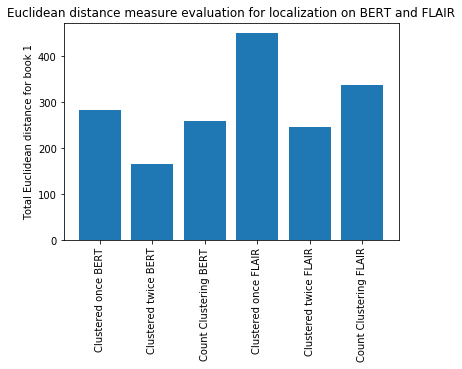

In [1079]:
import matplotlib.pyplot as plt
plt.bar([0, 1, 2, 3, 4, 5],[disclusteronce, disclustertwice, discountsclus, flairdisclusteronce, flairdisclustertwice, flairdiscountsclus])
plt.xticks([0, 1, 2, 3, 4, 5], ['Clustered once BERT', 'Clustered twice BERT', 'Count Clustering BERT', 'Clustered once FLAIR', 'Clustered twice FLAIR', 'Count Clustering FLAIR'], rotation=90)
plt.title('Euclidean distance measure evaluation for localization on BERT and FLAIR')
plt.ylabel('Total Euclidean distance for book 1')
plt.show()


In [1070]:
def get_times():
    allbooks = []
    for book in times:
        books = []
        for chapter in book:
            chapters = []
            for ner in chapter:
                try:
                    year = re.search('(\d{4})', ner[0])
                    if year != None:
                        chapters.append(ner[0])
                except:
                    asdfasdf=1       
            books.append(chapters)
        allbooks.append(books)
    return allbooks

In [1073]:
def localize_time():
    allbooks = get_times()

    bookpottimes = []
    overviewbook = []

    # get all the strings that are longer than 7 characters (month + year, e.g. May 1990)
    for book in allbooks:
        potentialtimes = []
        overview = []
        for chapter in book:
            perchapter = []
            for time in chapter:
                if len(time) >7:
                    perchapter.append(re.search('(\d{4})', time)[0])
                    overview.append(re.search('(\d{4})', time)[0])
            potentialtimes.append(perchapter)
        overviewbook.append(overview)
        bookpottimes.append(potentialtimes)

    allowedyearperbook = []
    # only keep years that are in the list more than one time or if they have a later occurence that is curyear+1
    for book in overviewbook:
        intlist = [int(x) for x in book]
        allowedyear = []
        for i in range(len(intlist)):
            curyear = intlist[i]
            for j in range(i+1, len(intlist)):
                if intlist[j] == curyear or intlist[j] == curyear+1:
                    allowedyear.append(intlist[j])
                    allowedyear.append(intlist[i])
        allowedyearperbook.append(list(np.unique(allowedyear)))

    # remove years that are before the minimum year of the previous book (from domain knowledge)
    minlastyear = 0
    for i in range(len(allowedyearperbook)-1):
        minlastyear = min(allowedyearperbook[i])
        while True:
            if allowedyearperbook[i+1][0] < minlastyear:
                allowedyearperbook[i+1] = allowedyearperbook[i+1][1:]
            else:
                break
    allowedyearperbook

    allbookstotal = []
    for i in range(len(allbooks)):
        chapters = []
        for chapter in allbooks[i]:
            added = False
            thischapter = []
            for time in chapter:
                years = re.findall('(\d{4})', time)
                for year in range(len(years)):
                    if int(years[year]) in allowedyearperbook[i]:
                        thischapter.append(years[year])
                        added = True
            if len(thischapter)>0:
                addedunique = False
                uniques = list(np.unique(thischapter))
                if len(uniques) > 1:
                    for unique in uniques:
                        if len(chapters)>0:
                            if unique == chapters[-1]:
                                chapters.append(unique)
                                addedunique = True
                    if not addedunique:
                        chapters.append(uniques[1])
                else:
                    chapters.append(uniques[0])
                
            else:
                if len(chapters)>0:
                    lastvalue = chapters[-1]
                    chapters.append(lastvalue)
                else:
                    chapters.append(-1)
        allbookstotal.append(chapters)
    write_to_file(allbookstotal, 'final_times.csv')
    return allbookstotal

In [730]:
def write_to_file(alllocs, filename):
    dataframed = pd.DataFrame(alllocs)
    dataframed.to_csv(filename)

In [1074]:
write_to_file(localize_time(), 'final_times.csv')

### Export annotations for visualization

In [1000]:
annotations = pd.read_csv('Annotations.txt')
transannotations = annotations.transpose()
annotations.to_csv('final_annotations.csv')